In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import product

import glob

from Code.Visualization import plot_grid2d, plot_grid3d
from Code.util import *

from scipy.stats import ttest_ind, norm
from scipy.spatial.distance import pdist

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = False
MM = 1/25.4

In [62]:
from sklearn.cluster import MeanShift
def ms_cluster(samples, bandwidth=0.2, min_bin_freq=20, min_cluster_size=30, ignore_range=0.95, plot=True):
    clusterer = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False, min_bin_freq=min_bin_freq)
    labels = clusterer.fit_predict(samples)
    unique_labels = np.unique(labels)

    centers = []
    to_del = []
    for l in unique_labels:
        if l == -1:
            continue
        m = samples[labels == l].mean(axis=0)
        if (labels == l).sum() < min_cluster_size: # Remove small clusters
            to_del.append(l)
            continue
        for i in range(3):
            if (m[i] > ignore_range) or (m[i] < -ignore_range):
                labels[labels == l] = -1
                to_del.append(l) # To indices
                break
        centers.append(m)
    unique_labels = np.delete(unique_labels, to_del)
    
    if len(unique_labels) == 1:
        raise RuntimeWarning('Only noise detected')

    if plot:
        plot_cluster(samples, labels, unique_labels)
        
    return unique_labels, labels, np.stack(centers, axis=0)

In [67]:
x = np.load('data/x/05110814.npy')
T = len(x)
bins = 40
a = np.load('data/a_400/u_05110814_500.npy')
spikes = np.random.poisson(lam=1/(1 + np.exp(-(a - 0.8) * 30)), size=(T, 4))
f, _ = hist3d(x, spikes, bins=bins, sigma=1)

12.25

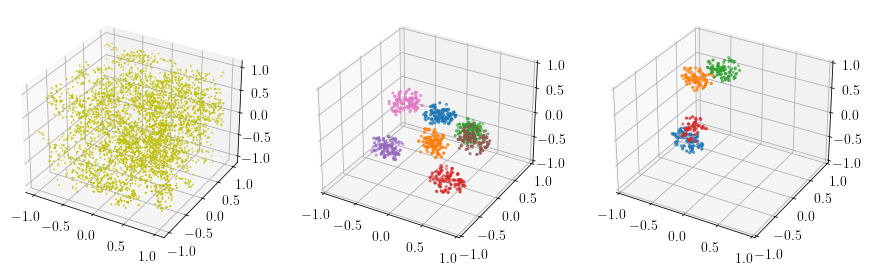

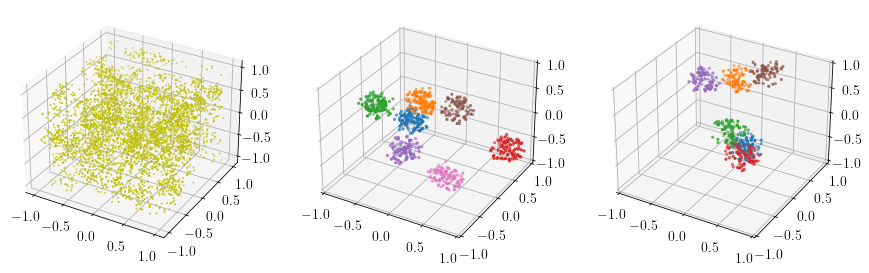

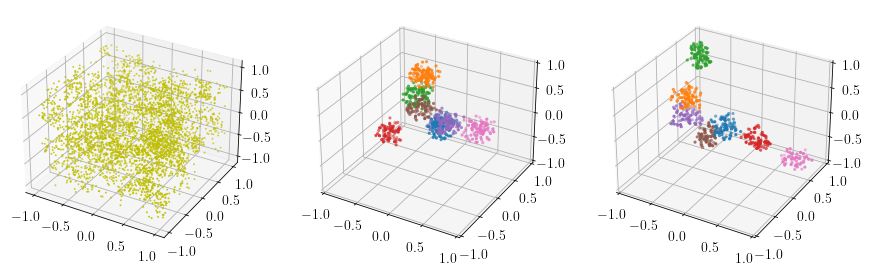

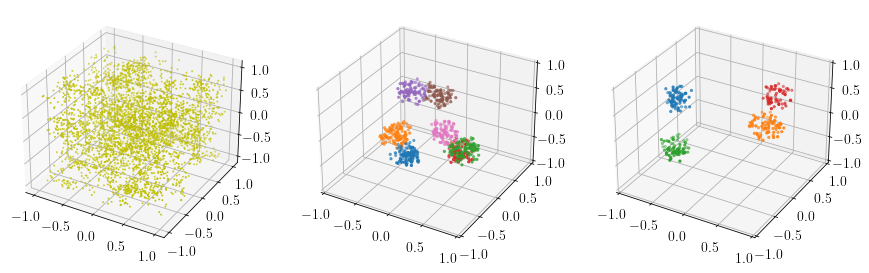

In [68]:
unique_labels = []
df = dict(nid=[], dist=[])
# df = dict(nid=[], label=[], x=[], y=[], z=[])

for i in range(a.shape[1]):
    samples = x[spikes[:, i] >= 1]
    res = ms_cluster(samples, 0.25, 25, 75)
    unique_labels.append(res[0])
    
    dist = pdist(res[2])
    df['nid'] += [i for _ in range(len(dist))]
    df['dist'] += list(dist)
    
#     for p in range(len(res[2])):
#         for q in range(p+1, len(res[2])):
#             df['nid'].append(i)
#             df['dist'].append(np.linalg.norm(res[2][p] - res[2][q]))
        
df = pd.DataFrame(df)
sum(map(len, unique_labels)) / a.shape[1] - 1

<AxesSubplot:xlabel='dist', ylabel='Density'>

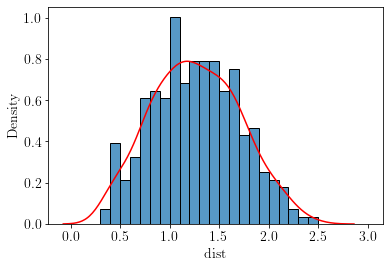

In [69]:
sns.histplot(data=df, x='dist', stat='density', bins=30, binrange=(0, 3))
sns.kdeplot(data=df, x='dist', color='r')

In [197]:
bins = 40
change_ints = (1, 5, 1e1, 5e1, 1e2, 5e2, 1e3, 5e3, 1e4, 5e4, 1e5)
col = ['tid', 'nid', r'$\kappa$', r'$\tau$', 'dist']
df_ifd = pd.DataFrame(index=np.arange(8*4*5*len(change_ints)*1200), columns=col)

count = 0
for _, xfname in enumerate(glob.glob('data/x/*.npy')):
    tid = xfname[7:15]
    x = np.load(xfname)
    T = len(x)
    p, xs = hist3d(x, bins=bins)
    
    for i, change_int in enumerate(change_ints):
        for kappa in (300, 400, 500, 600, 'c'):
            c = 'c' if kappa == 'c' else 'u'
            a = np.load('data/a_%s/%s_%s_%d.npy' % (kappa, c, tid, change_int))
            spikes = np.random.poisson(lam=1/(1 + np.exp(-(a - 0.7) * 30)), size=(T, 4))
            f, _ = hist3d(x, spikes, bins=bins, sigma=1.75)
            
            for k in range(4):
                samples = x[spikes[:, k] >= 1]
                res = ms_cluster(samples, 0.25, 25, 75, plot=False)
                
                dist = pdist(res[2])
                l = dist.shape[0]
                
                df_ifd.loc[count:count+l-1, 'tid'] = tid
                df_ifd.loc[count:count+l-1, 'nid'] = k
                df_ifd.loc[count:count+l-1, r'$\kappa$'] = r'$\infty$' if kappa == 'c' else kappa
                df_ifd.loc[count:count+l-1, r'$\tau$'] = change_int
                df_ifd.loc[count:count+l-1, 'dist'] = dist
                count += l
            
df_ifd.dropna(how='all', inplace=True)
df_ifd.loc[:, r'$\tau$'] = df_ifd[r'$\tau$'].astype(np.int32)
df_ifd.loc[:, r'$\log_{10} \tau$'] = np.log10(df_ifd[r'$\tau$'])
df_ifd.loc[:, 'dist'] = df_ifd['dist'].astype(np.float64)

In [198]:
# df_ifd.to_csv('data/analysis/ifd.csv', index=False)

In [2]:
df_ifd = pd.read_csv('data/analysis/ifd.csv')

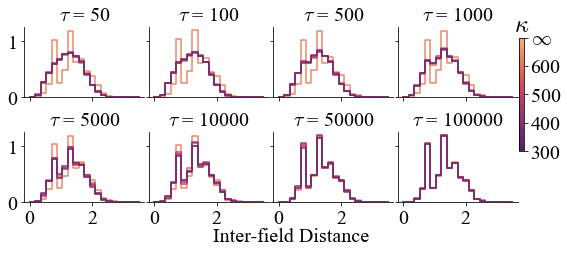

In [30]:
plt.rcParams.update({'font.size': 20})
g = sns.FacetGrid(data=df_ifd[df_ifd[r'$\tau$'] > 10], col=r'$\tau$', col_wrap=4, 
                  hue=r'$\kappa$', hue_order=[r'$\infty$', '600', '500', '400', '300'], 
                  palette='flare', margin_titles=True, aspect=1.5, height=1.5)
g.map_dataframe(sns.histplot, x='dist', stat='density', bins=20, binrange=(0, 3.5), fill=False, element='step')
g.set_xlabels('')
g.fig.text(0.4, -0.05, 'Inter-field Distance')

g.tight_layout(pad=0.1)

cax =  g.fig.add_axes([1, 0.35, 0.008, 0.5])
norm = mpl.colors.Normalize(vmin=300, vmax=700)
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=sns.color_palette('flare_r', as_cmap=True)), 
                    cax=cax, orientation='vertical', ticks=[300, 400, 500, 600, 700])
cbar.ax.set_yticklabels([300, 400, 500, 600, r'$\infty$'])
cbar.ax.set_title(r'$\kappa$')

g.fig.set_size_inches(180*MM, 80*MM)
g.savefig('figures/sample_ifd.pdf', transparent=True, dpi=300, pad_inches=0, bbox_inches='tight')